In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import awkward as ak
import vector
import mplhep as hep
hep.style.use(hep.style.CMS)
import tensorflow as tf
import tensorflow.keras
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score, confusion_matrix, auc, roc_curve
from tensorflow.keras.layers import Dense, Dropout, LSTM, concatenate, GRU,Masking, Activation, TimeDistributed, Conv1D, BatchNormalization, MaxPooling1D, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.backend import sigmoid
from tensorflow.keras import regularizers
from keras.utils.generic_utils import get_custom_objects
import sys
import random
from math import sqrt
from tqdm import tqdm
import pickle as pkl

2022-12-07 13:41:15.557116: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-6cb32/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-90caf/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorfl

In [2]:
seed_value= 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
np.random.seed(seed_value)
import keras
import tensorflow as tf
tf.random.set_seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
from keras import backend as K
K.set_session(sess)

2022-12-07 13:41:24.296095: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-07 13:41:24.300553: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-6cb32/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-90caf/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-pack

In [3]:
'''dnn_name = 'DNN_phase1_test'
folder = './DNNmodel/'+dnn_name+'/'
if not os.path.exists(folder):
    os.mkdir(folder)'''

"dnn_name = 'DNN_phase1_test'\nfolder = './DNNmodel/'+dnn_name+'/'\nif not os.path.exists(folder):\n    os.mkdir(folder)"

In [4]:
file = open("/eos/home-a/acagnott/DarkMatter/trainingSet/trainingset.pkl", "rb")
dict_samples = pkl.load(file)
file.close()

In [5]:
categories = ['3j0fj']
datasets = ['tDM_mPhi1000_mChi1', 'QCD_HT1000', 'TT_Mtt-700to1000', 'TT_Mtt-1000toInf']

In [6]:
for d in datasets:
    for c in categories:
        idx_falsetop = [i for i, x in enumerate(dict_samples[d][c][3]==0) if x==True]
        ids_todrop = random.sample(idx_falsetop, int(len(idx_falsetop)*(8/10)))
        dict_samples[d][c][0] = np.delete(dict_samples[d][c][0], ids_todrop, axis=0)
        dict_samples[d][c][1] = np.delete(dict_samples[d][c][1], ids_todrop, axis=0)
        dict_samples[d][c][2] = np.delete(dict_samples[d][c][2], ids_todrop, axis=0)
        dict_samples[d][c][3] = np.delete(dict_samples[d][c][3], ids_todrop, axis=0)
        dict_samples[d][c][4] = np.delete(dict_samples[d][c][4], ids_todrop, axis=0)

In [7]:
dict_samples[d][c][0]

array([[[ 5.18554688e-01,  2.76489258e-02, -3.42956264e+00, ...,
          4.91562500e+01,  2.68066406e+00, -1.91235352e+00],
        [ 4.78759766e-01,  9.75799561e-03, -2.33617885e+00, ...,
          1.15000000e+02,  2.91308594e+00, -8.18969727e-01],
        [ 5.18554688e-01,  5.69335938e-01,  4.89138531e-01, ...,
          1.25437500e+02, -8.57666016e-01,  2.00634766e+00]],

       [[ 5.18554688e-01,  2.76489258e-02, -4.66327676e+00, ...,
          4.91562500e+01,  2.68066406e+00, -1.91235352e+00],
        [ 5.08789062e-01,  3.77441406e-01, -4.20063027e+00, ...,
          5.99375000e+01,  2.04833984e+00, -1.44970703e+00],
        [ 5.18554688e-01,  5.69335938e-01, -7.44575586e-01, ...,
          1.25437500e+02, -8.57666016e-01,  2.00634766e+00]],

       [[ 5.18554688e-01,  2.76489258e-02, -5.36227895e-01, ...,
          4.91562500e+01,  2.68066406e+00, -1.91235352e+00],
        [ 5.08789062e-01,  3.77441406e-01, -7.35814110e-02, ...,
          5.99375000e+01,  2.04833984e+00, -1.449

In [8]:
pt_sep = 250

In [9]:
X_jet_lowpt = np.concatenate([dict_samples[d][c][0][:,:,:-2][dict_samples[d][c][-1].reshape(-1)<pt_sep]
                              for d in datasets for c in categories ])
#X_fatjet_lowpt = np.concatenate([dict_samples[d][c][1][dict_samples[d][c][-1].reshape(-1)<pt_sep]
#                                 for d in datasets for c in categories])
X_mass_lowpt = np.concatenate([dict_samples[d][c][2][dict_samples[d][c][-1].reshape(-1)<pt_sep]
                               for d in datasets for c in categories])
                          
y_lowpt = np.concatenate([dict_samples[d][c][3][dict_samples[d][c][-1].reshape(-1)<pt_sep]
                          for d in datasets for c in categories] )

In [10]:
X_jet_lowpt[0, :].shape, y_lowpt[0]

((3, 6), array([1.]))

In [11]:
X_jet_lowpt_train, X_jet_lowpt_test, X_mass_lowpt_train, X_mass_lowpt_test, y_lowpt_train, y_lowpt_test = train_test_split(X_jet_lowpt, X_mass_lowpt, y_lowpt, stratify=y_lowpt, shuffle=True, test_size=0.3)

In [12]:
#((86179, 3, 8), (36935, 3, 8))  --> training set, test set 
#(968.0, 415.0) ---> true event in train, test

In [13]:
X_jet_lowpt_train.shape, X_jet_lowpt_test.shape, 

((10000, 3, 6), (4286, 3, 6))

In [14]:
np.sum(y_lowpt_train), np.sum(y_lowpt_test) 

(645.0, 276.0)

In [15]:
dropout = 0.1

jet_inputs = tf.keras.Input(shape=(None,X_jet_lowpt_train.shape[2],), name = 'jet')    #y
#mass_input = tf.keras.Input(shape=(2, ), name = 'top_mass')
#x = Masking(mask_value=0)(fj_inputs) # ultima modifica

#y = Masking(mask_value=0.)(jet_inputs)
y = BatchNormalization()(jet_inputs)
y = keras.layers.LSTM(1, activation='tanh')(y)

y = Dense(5)(y)
y= Dropout(dropout)(y)
outputs = Dense(1, activation='sigmoid')(y) 
#model = tf.keras.Model(inputs=[fj_inputs, jet_inputs, mass_input], outputs=outputs)
model1 = tf.keras.Model(inputs=[jet_inputs], outputs=outputs)

In [16]:
dropout = 0.1

jet0_inputs = tf.keras.Input(shape=(X_jet_lowpt_train.shape[2],), name = 'jet0')    #y
jet1_inputs = tf.keras.Input(shape=(X_jet_lowpt_train.shape[2],), name = 'jet1')
jet2_inputs = tf.keras.Input(shape=(X_jet_lowpt_train.shape[2],), name = 'jet2')
#mass_input = tf.keras.Input(shape=(2, ), name = 'top_mass')
#x = Masking(mask_value=0)(fj_inputs) # ultima modifica

y0 = Masking(mask_value=0.)(jet0_inputs)
y1 = Masking(mask_value=0.)(jet1_inputs)
y2 = Masking(mask_value=0.)(jet2_inputs)
y0 = BatchNormalization()(y0)
y1 = BatchNormalization()(y1)
y2 = BatchNormalization()(y2)

y = concatenate([y0,y1,y2])
y = Dense(20, activation='tanh')(y)
y = Dropout(dropout)(y)

outputs = Dense(1, activation='sigmoid')(y) 
#model = tf.keras.Model(inputs=[fj_inputs, jet_inputs, mass_input], outputs=outputs)
model2 = tf.keras.Model(inputs=[jet0_inputs, jet1_inputs, jet2_inputs], outputs=outputs)

In [17]:
trainer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.BinaryCrossentropy()
model1.compile(optimizer=trainer, loss=loss, metrics=[tf.keras.metrics.AUC()])

In [18]:
trainer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.BinaryCrossentropy()
model2.compile(optimizer=trainer, loss=loss, metrics=[tf.keras.metrics.AUC()])

In [19]:
model1.summary(), model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 jet (InputLayer)            [(None, None, 6)]         0         
                                                                 
 batch_normalization (BatchN  (None, None, 6)          24        
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 1)                 32        
                                                                 
 dense (Dense)               (None, 5)                 10        
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                             

(None, None)

In [20]:
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                           mode='min',# quantity that has to be monitored(to be minimized in this case)
                                           patience = 50, # Number of epochs with no improvement after which training will be stopped.
                                           min_delta = 1e-8,
                                           restore_best_weights = True) # update the model with the best-seen weights

#Reduce learning rate when a metric has stopped improving
reduce_LR = keras.callbacks.ReduceLROnPlateau(monitor = 'auc',
                                              mode='max',# quantity that has to be monitored
                                              min_delta=1e-4,
                                              factor = 0.5, # factor by which LR has to be reduced...
                                              patience = 50, #...after waiting this number of epochs with no improvements 
                                              #on monitored quantity
                                              min_lr= 1e-15 ) 


#callback_list = [reduce_LR, early_stop]
callback_list = [early_stop]

In [21]:
epochs = 10000
batch_size = 50

#history = model.fit({'fatjet': X_fatjet_train, 'jet':X_jet_train, 'top_mass': X_mass_train}, y_train, callbacks=callback_list, 
#                    validation_split = 0.1,
#                    epochs=epochs, batch_size=batch_size, verbose=1)
history1 = model1.fit({'jet':X_jet_lowpt_train}, y_lowpt_train, callbacks=callback_list, 
                    validation_split = 0.2,
                    epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/10000
160/160 [==============================] - 5s 9ms/step - loss: 0.2810 - auc: 0.5327 - val_loss: 0.2310 - val_auc: 0.7493
Epoch 2/10000
160/160 [==============================] - 1s 3ms/step - loss: 0.2183 - auc: 0.7163 - val_loss: 0.2173 - val_auc: 0.7881
Epoch 3/10000
160/160 [==============================] - 1s 4ms/step - loss: 0.2125 - auc: 0.7487 - val_loss: 0.2161 - val_auc: 0.8004
Epoch 4/10000
160/160 [==============================] - 1s 4ms/step - loss: 0.2077 - auc: 0.7631 - val_loss: 0.2085 - val_auc: 0.8126
Epoch 5/10000
160/160 [==============================] - 1s 3ms/step - loss: 0.2053 - auc: 0.7744 - val_loss: 0.2073 - val_auc: 0.8222
Epoch 6/10000
160/160 [==============================] - 1s 3ms/step - loss: 0.2023 - auc: 0.7845 - val_loss: 0.2059 - val_auc: 0.8218
Epoch 7/10000
160/160 [==============================] - 1s 4ms/step - loss: 0.2022 - auc: 0.7888 - val_loss: 0.2101 - val_auc: 0.8198
Epoch 8/10000
160/160 [==============================] 

160/160 [==============================] - 1s 4ms/step - loss: 0.1543 - auc: 0.9059 - val_loss: 0.1624 - val_auc: 0.9130
Epoch 62/10000
160/160 [==============================] - 1s 4ms/step - loss: 0.1524 - auc: 0.9088 - val_loss: 0.1612 - val_auc: 0.9120
Epoch 63/10000
160/160 [==============================] - 1s 4ms/step - loss: 0.1534 - auc: 0.9067 - val_loss: 0.1575 - val_auc: 0.9143
Epoch 64/10000
160/160 [==============================] - 1s 4ms/step - loss: 0.1497 - auc: 0.9107 - val_loss: 0.1614 - val_auc: 0.9160
Epoch 65/10000
160/160 [==============================] - 1s 4ms/step - loss: 0.1534 - auc: 0.9033 - val_loss: 0.1592 - val_auc: 0.9125
Epoch 66/10000
160/160 [==============================] - 1s 4ms/step - loss: 0.1540 - auc: 0.9061 - val_loss: 0.1613 - val_auc: 0.9126
Epoch 67/10000
160/160 [==============================] - 1s 3ms/step - loss: 0.1524 - auc: 0.9085 - val_loss: 0.1589 - val_auc: 0.9138
Epoch 68/10000
160/160 [==============================] - 1s 4m

160/160 [==============================] - 1s 3ms/step - loss: 0.1552 - auc: 0.9021 - val_loss: 0.1642 - val_auc: 0.9127
Epoch 122/10000
160/160 [==============================] - 1s 3ms/step - loss: 0.1518 - auc: 0.9076 - val_loss: 0.1569 - val_auc: 0.9120
Epoch 123/10000
160/160 [==============================] - 1s 4ms/step - loss: 0.1533 - auc: 0.9039 - val_loss: 0.1612 - val_auc: 0.9133
Epoch 124/10000
160/160 [==============================] - 1s 4ms/step - loss: 0.1527 - auc: 0.9071 - val_loss: 0.1617 - val_auc: 0.9120
Epoch 125/10000
160/160 [==============================] - 1s 4ms/step - loss: 0.1557 - auc: 0.9031 - val_loss: 0.1574 - val_auc: 0.9108
Epoch 126/10000
160/160 [==============================] - 1s 4ms/step - loss: 0.1508 - auc: 0.9103 - val_loss: 0.1575 - val_auc: 0.9122
Epoch 127/10000
160/160 [==============================] - 1s 4ms/step - loss: 0.1545 - auc: 0.9037 - val_loss: 0.1604 - val_auc: 0.9119
Epoch 128/10000
160/160 [==============================] 

In [22]:
epochs = 10000
batch_size = 200

#history = model.fit({'fatjet': X_fatjet_train, 'jet':X_jet_train, 'top_mass': X_mass_train}, y_train, callbacks=callback_list, 
#                    validation_split = 0.1,
#                    epochs=epochs, batch_size=batch_size, verbose=1)
history2 = model2.fit({'jet0':X_jet_lowpt_train[:,0], 'jet1':X_jet_lowpt_train[:,1], 'jet2':X_jet_lowpt_train[:,2]}, 
                     y_lowpt_train, callbacks=callback_list, 
                    validation_split = 0.2,
                    epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/10000
40/40 [==============================] - 2s 14ms/step - loss: 0.3714 - auc_1: 0.5405 - val_loss: 0.3366 - val_auc_1: 0.5585
Epoch 2/10000
40/40 [==============================] - 0s 3ms/step - loss: 0.2309 - auc_1: 0.6673 - val_loss: 0.2519 - val_auc_1: 0.6974
Epoch 3/10000
40/40 [==============================] - 0s 3ms/step - loss: 0.2219 - auc_1: 0.7015 - val_loss: 0.2403 - val_auc_1: 0.7300
Epoch 4/10000
40/40 [==============================] - 0s 3ms/step - loss: 0.2197 - auc_1: 0.7139 - val_loss: 0.2308 - val_auc_1: 0.7445
Epoch 5/10000
40/40 [==============================] - 0s 4ms/step - loss: 0.2203 - auc_1: 0.7113 - val_loss: 0.2403 - val_auc_1: 0.7498
Epoch 6/10000
40/40 [==============================] - 0s 3ms/step - loss: 0.2208 - auc_1: 0.7117 - val_loss: 0.2264 - val_auc_1: 0.7606
Epoch 7/10000
40/40 [==============================] - 0s 3ms/step - loss: 0.2194 - auc_1: 0.7157 - val_loss: 0.2338 - val_auc_1: 0.7635
Epoch 8/10000
40/40 [===================

40/40 [==============================] - 0s 3ms/step - loss: 0.1529 - auc_1: 0.9093 - val_loss: 0.1467 - val_auc_1: 0.9347
Epoch 61/10000
40/40 [==============================] - 0s 3ms/step - loss: 0.1471 - auc_1: 0.9158 - val_loss: 0.1482 - val_auc_1: 0.9359
Epoch 62/10000
40/40 [==============================] - 0s 3ms/step - loss: 0.1482 - auc_1: 0.9160 - val_loss: 0.1441 - val_auc_1: 0.9369
Epoch 63/10000
40/40 [==============================] - 0s 3ms/step - loss: 0.1484 - auc_1: 0.9164 - val_loss: 0.1479 - val_auc_1: 0.9346
Epoch 64/10000
40/40 [==============================] - 0s 3ms/step - loss: 0.1468 - auc_1: 0.9147 - val_loss: 0.1477 - val_auc_1: 0.9325
Epoch 65/10000
40/40 [==============================] - 0s 3ms/step - loss: 0.1472 - auc_1: 0.9187 - val_loss: 0.1457 - val_auc_1: 0.9362
Epoch 66/10000
40/40 [==============================] - 0s 3ms/step - loss: 0.1479 - auc_1: 0.9157 - val_loss: 0.1464 - val_auc_1: 0.9338
Epoch 67/10000
40/40 [===========================

40/40 [==============================] - 0s 3ms/step - loss: 0.1398 - auc_1: 0.9280 - val_loss: 0.1449 - val_auc_1: 0.9335
Epoch 120/10000
40/40 [==============================] - 0s 3ms/step - loss: 0.1403 - auc_1: 0.9251 - val_loss: 0.1509 - val_auc_1: 0.9316
Epoch 121/10000
40/40 [==============================] - 0s 3ms/step - loss: 0.1415 - auc_1: 0.9248 - val_loss: 0.1531 - val_auc_1: 0.9274
Epoch 122/10000
40/40 [==============================] - 0s 3ms/step - loss: 0.1388 - auc_1: 0.9247 - val_loss: 0.1466 - val_auc_1: 0.9327
Epoch 123/10000
40/40 [==============================] - 0s 3ms/step - loss: 0.1386 - auc_1: 0.9293 - val_loss: 0.1477 - val_auc_1: 0.9318
Epoch 124/10000
40/40 [==============================] - 0s 3ms/step - loss: 0.1397 - auc_1: 0.9252 - val_loss: 0.1483 - val_auc_1: 0.9285
Epoch 125/10000
40/40 [==============================] - 0s 3ms/step - loss: 0.1434 - auc_1: 0.9230 - val_loss: 0.1444 - val_auc_1: 0.9332
Epoch 126/10000
40/40 [====================

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


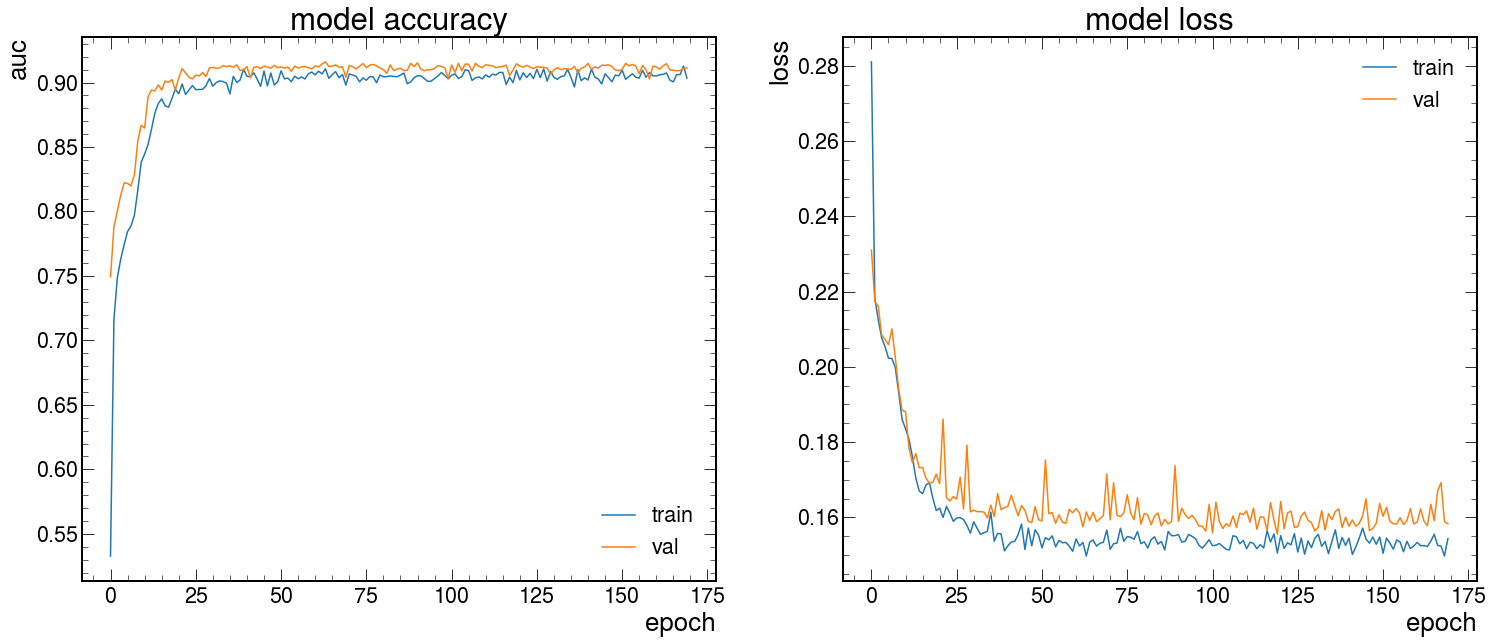

In [43]:
# list all data in history
print(history1.history.keys())
# summarize history for accuracy
fig, ax = plt.subplots(ncols=2, figsize=(25,10))
for var in history1.history.keys():
    if ('loss' in var) and (not 'val' in var): ax[1].plot(history1.history[var], label ='train')
    if 'val_loss' in var: ax[1].plot(history1.history[var], label ='val')
    if ('auc' in var) and (not 'val' in var): ax[0].plot(history1.history[var], label ='train')
    if 'val_auc' in var : ax[0].plot(history1.history[var], label ='val')

ax[0].set_title('model accuracy')
ax[0].set_ylabel('auc')
ax[0].set_xlabel('epoch')
ax[0].legend()
# summarize history for loss
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend()
#ax[1].set_yscale('Log')
plt.savefig(folder+'auc_loss_LSTM.png')

dict_keys(['loss', 'auc_1', 'val_loss', 'val_auc_1'])


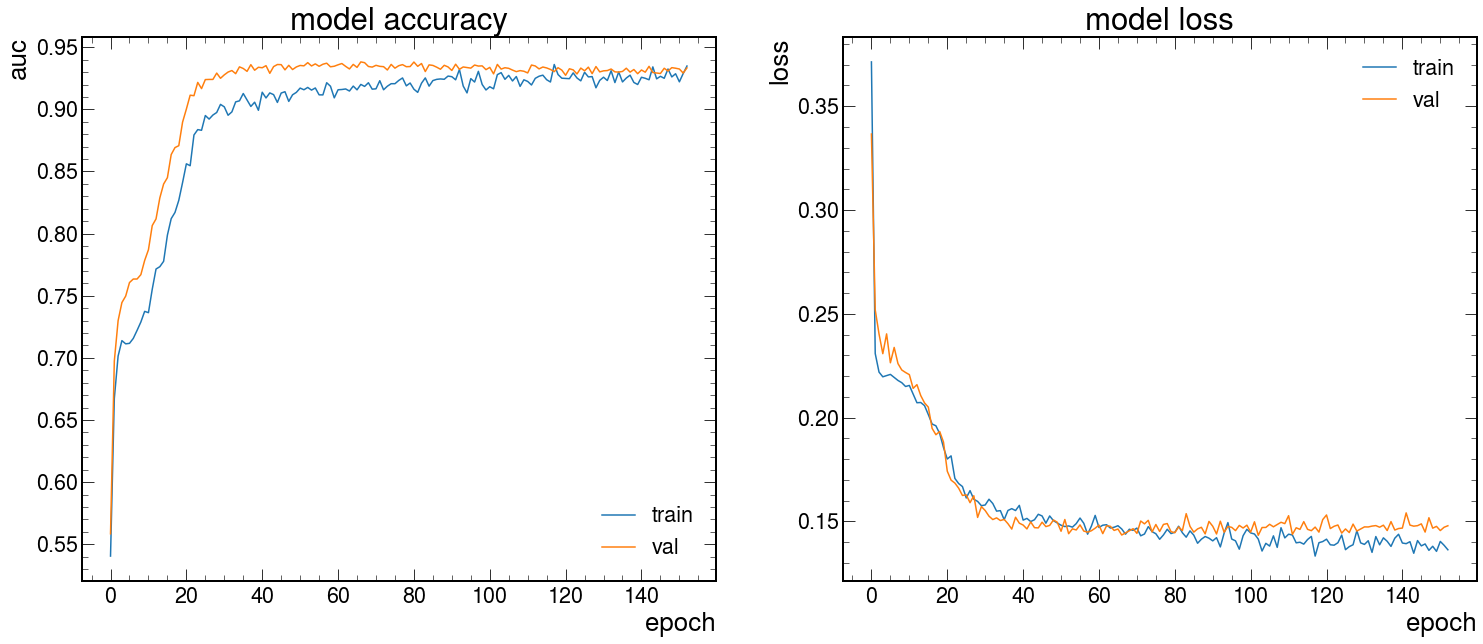

In [42]:
# list all data in history
print(history2.history.keys())
# summarize history for accuracy
fig, ax = plt.subplots(ncols=2, figsize=(25,10))
for var in history2.history.keys():
    if ('loss' in var) and (not 'val' in var): ax[1].plot(history2.history[var], label ='train')
    if 'val_loss' in var: ax[1].plot(history2.history[var], label ='val')
    if ('auc' in var) and (not 'val' in var): ax[0].plot(history2.history[var], label ='train')
    if 'val_auc' in var : ax[0].plot(history2.history[var], label ='val')

ax[0].set_title('model accuracy')
ax[0].set_ylabel('auc')
ax[0].set_xlabel('epoch')
ax[0].legend()
# summarize history for loss
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend()
#ax[1].set_yscale('Log')
plt.savefig(folder+'auc_loss_DNN.png')

In [25]:
#model.evaluate({'fatjet': X_fatjet_test, 'jet': X_jet_test, 'top_mass': X_mass_test}, y_test)
model1.evaluate({'jet': X_jet_lowpt_test}, y_lowpt_test)
model2.evaluate({'jet0':X_jet_lowpt_test[:,0], 'jet1':X_jet_lowpt_test[:,1], 'jet2':X_jet_lowpt_test[:,2]}, y_lowpt_test)

134/134 [==============================] - 1s 2ms/step - loss: 0.1362 - auc_1: 0.9388


[0.13619685173034668, 0.938808798789978]

In [26]:
#y_pred = model.predict({'fatjet': X_fatjet_test, 'jet': X_jet_test, 'top_mass': X_mass_test})
#y_pred_train = model.predict({'fatjet': X_fatjet_train, 'jet': X_jet_train, 'top_mass': X_mass_train})
y_pred1 = model1.predict({'jet': X_jet_lowpt_test})
y_pred_train1 = model1.predict({'jet': X_jet_lowpt_train})

In [27]:
y_pred2 = model2.predict({'jet0':X_jet_lowpt_test[:,0], 'jet1':X_jet_lowpt_test[:,1], 'jet2':X_jet_lowpt_test[:,2]})
y_pred_train2 = model2.predict({'jet0':X_jet_lowpt_train[:,0], 'jet1':X_jet_lowpt_train[:,1], 'jet2':X_jet_lowpt_train[:,2]})

In [28]:
y_pred_train_bkg1 = y_pred_train1[y_lowpt_train==0]
y_pred_train_sgn1 = y_pred_train1[y_lowpt_train==1]
y_pred_bkg1 = y_pred1[y_lowpt_test==0]
y_pred_sgn1 = y_pred1[y_lowpt_test==1]

In [29]:
y_pred_train_bkg2 = y_pred_train2[y_lowpt_train==0]
y_pred_train_sgn2 = y_pred_train2[y_lowpt_train==1]
y_pred_bkg2 = y_pred2[y_lowpt_test==0]
y_pred_sgn2 = y_pred2[y_lowpt_test==1]

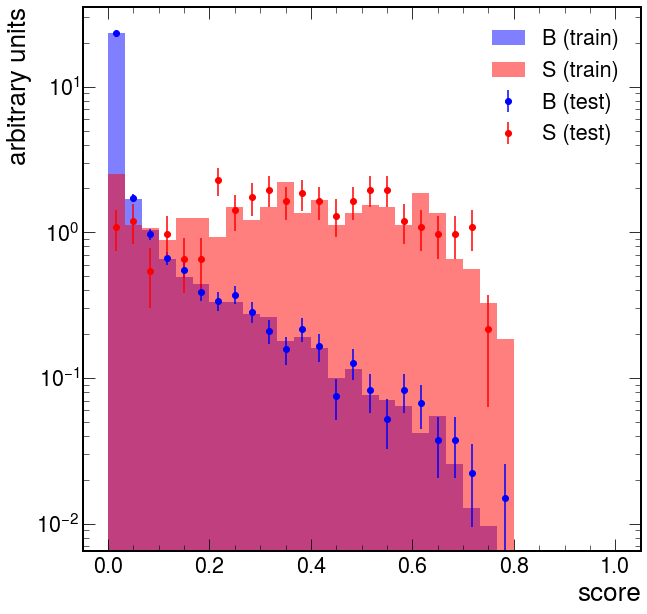

In [40]:
bins = 30

fig, ax = plt.subplots(figsize=(10,10))


bins_count_bkg = ax.hist(y_pred_train_bkg1, alpha=0.5, color='blue', 
                         density=True, label='B (train)', range = [0,1], bins = bins)
bins_count_sgn = ax.hist(y_pred_train_sgn1, alpha=0.5,color='red', 
                         density=True, label='S (train)', range = [0,1], bins = bins)

hist, bins = np.histogram(y_pred_bkg1, range = [0,1], bins=bins, density=True)
scale = len(y_pred_bkg1) / sum(hist)
err = np.sqrt(hist * scale) / scale
center = (bins[:-1] + bins[1:]) / 2
ax.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')

hist, bins = np.histogram(y_pred_sgn1, range = [0,1], bins=bins, density=True)
scale = len(y_pred_sgn1) / sum(hist)
err = np.sqrt(hist * scale) / scale
center = (bins[:-1] + bins[1:]) / 2
ax.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')

ax.set_xlabel('score')
ax.set_ylabel('arbitrary units')
ax.legend()
plt.yscale('Log')
plt.savefig(folder+'traintestDiscrimination_LSTM.png')

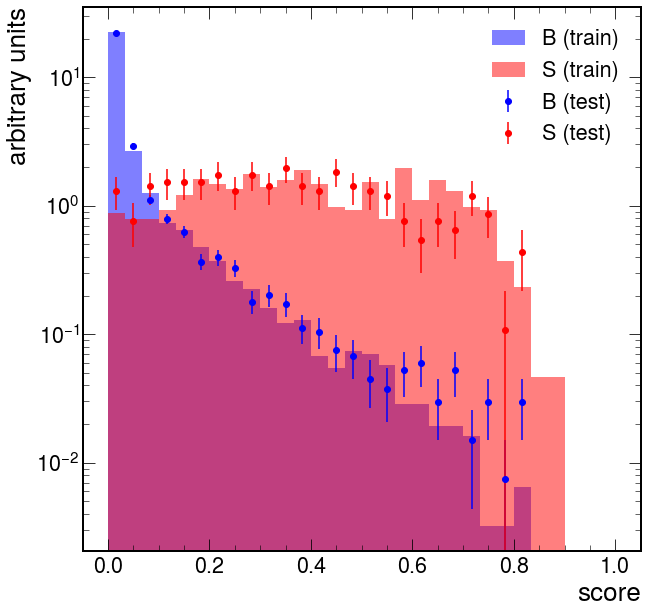

In [41]:
bins = 30

fig, ax = plt.subplots(figsize=(10,10))


bins_count_bkg = ax.hist(y_pred_train_bkg2, alpha=0.5, color='blue', 
                         density=True, label='B (train)', range = [0,1], bins = bins)
bins_count_sgn = ax.hist(y_pred_train_sgn2, alpha=0.5,color='red', 
                         density=True, label='S (train)', range = [0,1], bins = bins)

hist, bins = np.histogram(y_pred_bkg2, range = [0,1], bins=bins, density=True)
scale = len(y_pred_bkg2) / sum(hist)
err = np.sqrt(hist * scale) / scale
center = (bins[:-1] + bins[1:]) / 2
ax.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')

hist, bins = np.histogram(y_pred_sgn2, range = [0,1], bins=bins, density=True)
scale = len(y_pred_sgn2) / sum(hist)
err = np.sqrt(hist * scale) / scale
center = (bins[:-1] + bins[1:]) / 2
ax.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')

ax.set_xlabel('score')
ax.set_ylabel('arbitrary units')
ax.legend()
plt.yscale('Log')
plt.savefig(folder+'traintestDiscrimination_DNN.png')

In [32]:
y_score1 = y_pred1.ravel()
print(len(y_score1))
y_true1 = y_lowpt_test.ravel()
print(len(y_true1))
y_score2 = y_pred2.ravel()
print(len(y_score2))
y_true2 = y_lowpt_test.ravel()
print(len(y_true2))

4286
4286
4286
4286


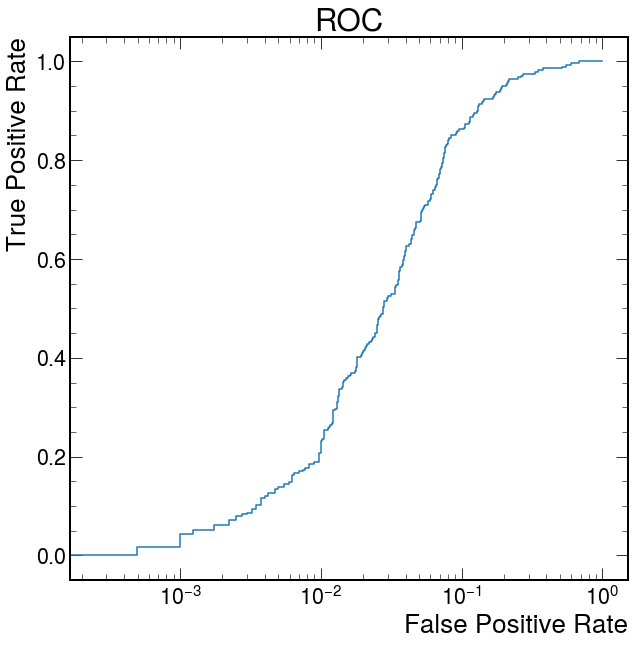

In [44]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr1, tpr1, trs1 =roc_curve(y_true = y_true1, y_score = y_score1, pos_label=1)
fig, ax = plt.subplots()
ax.plot(fpr, tpr) 
ax.set_title('ROC')
ax.set_xlabel('False Positive Rate') 
ax.set_ylabel('True Positive Rate') 
plt.xscale('Log')
plt.savefig(folder+'ROC_LSTM.png')

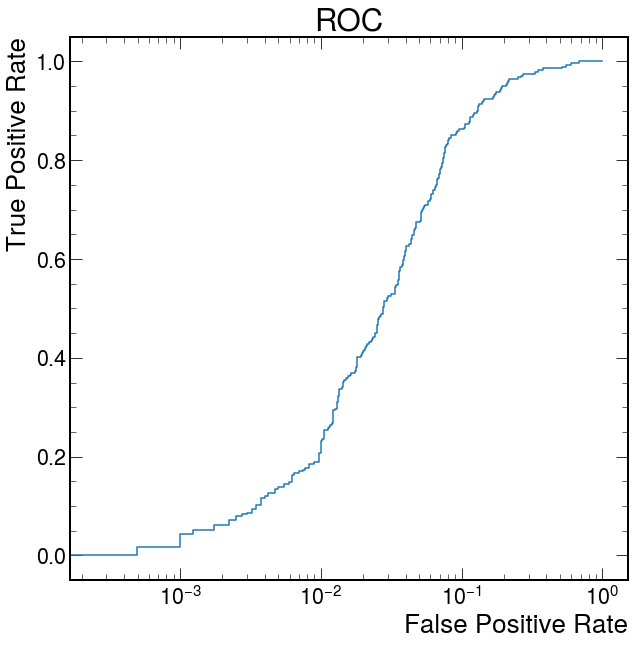

In [45]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr2, tpr2, trs2 =roc_curve(y_true = y_true2, y_score = y_score2, pos_label=1)
fig, ax = plt.subplots()
ax.plot(fpr, tpr) 
ax.set_title('ROC')
ax.set_xlabel('False Positive Rate') 
ax.set_ylabel('True Positive Rate') 
plt.xscale('Log')

plt.savefig(folder+'ROC_DNN.png')

In [36]:
dnn_name = 'DNN_phase1_test_lowpt_LSTM'
folder = './DNNmodel/'+dnn_name+'/'
if not os.path.exists(folder):
    os.mkdir(folder)
model1.save(folder+dnn_name+".h5")

In [37]:
dnn_name = 'DNN_phase1_test_lowpt_DNN'
folder = './DNNmodel/'+dnn_name+'/'
if not os.path.exists(folder):
    os.mkdir(folder)
model2.save(folder+dnn_name+".h5")

In [ ]:
print('10%   trs', trs[fpr<0.1][-1], 'tpr ',tpr[fpr<0.1][-1])
print('5%    trs',trs[fpr<0.05][-1], 'tpr ', tpr[fpr<0.05][-1])
print('1%    trs',trs[fpr<0.01][-1], 'tpr ', tpr[fpr<0.01][-1])
print('0.1%  trs',trs[fpr<0.001][-1], 'tpr ', tpr[fpr<0.001][-1])

In [46]:
tresholds = {'fpr 10': trs1[fpr1<0.1][-1], 
      'fpr 5': trs1[fpr1<0.05][-1], 
      'fpr 1': trs1[fpr1<0.01][-1], 
      'fpr 01':trs1[fpr1<0.001][-1]}
with open(folder+"tresholds_LSTM.pkl", "wb") as file:
    pkl.dump(tresholds, file)

In [47]:
tresholds = {'fpr 10': trs2[fpr2<0.1][-1], 
      'fpr 5': trs2[fpr2<0.05][-1], 
      'fpr 1': trs2[fpr2<0.01][-1], 
      'fpr 01':trs2[fpr2<0.001][-1]}
with open(folder+"tresholds_DNN.pkl", "wb") as file:
    pkl.dump(tresholds, file)

In [ ]:
t = [trs[fpr<0.1][-1], trs[fpr<0.05][-1], trs[fpr<0.01][-1], trs[fpr<0.001][-1]]

In [ ]:
model = keras.models.load_model(folder+dnn_name+".h5")

In [ ]:
file = open("/eos/home-a/acagnott/DarkMatter/trainingSet/trainingset.pkl", "rb")
dict_samples = pkl.load(file)
file.close()

In [ ]:
X_jet = np.concatenate([dict_samples[d][c][0][dict_samples[d][c][-1].reshape(-1)<pt_sep] for d in datasets for c in categories ])
X_fatjet = np.concatenate([dict_samples[d][c][1][dict_samples[d][c][-1].reshape(-1)<pt_sep] for d in datasets for c in categories])
X_mass = np.concatenate([dict_samples[d][c][2][dict_samples[d][c][-1].reshape(-1)<pt_sep] for d in datasets for c in categories])
                          
y = np.concatenate([dict_samples[d][c][3][dict_samples[d][c][-1].reshape(-1)<pt_sep] for d in datasets for c in categories] )

In [ ]:
pred_all = model1.predict({'jet': X_jet})
#pred_all = model2.predict({'jet0':X_jet[:,0], 'jet1':X_jet[:,1], 'jet2':X_jet[:,2]})

In [ ]:
with open(folder+"tresholds.pkl", "rb") as file:
    tresholds=pkl.load(file)

In [ ]:
fig, ax = plt.subplots(ncols = 4, figsize = (40, 10))
bins = 50
rg = [0,500]
for n, tr in enumerate(tresholds.values()):
    ax[n].hist(X_mass[:,1][(pred_all.flatten()>tr)*(y.flatten()==1)], histtype = 'step',range = rg, bins = bins, label = 'true signal' )
    ax[n].hist(X_mass[:,1][(pred_all.flatten()>tr)*(y.flatten()==0)], histtype = 'step',range = rg, bins = bins, label = 'false signal' )
    ax[n].legend()
    ax[n].set_title('tres '+str(round(tr, 3)))
    ax[n].set_yscale('Log')
    print('tpr, fpr')
    print(len(X_mass[:,1][(pred_all.flatten()>tr)*(y.flatten()==1)])/len(X_mass[:,1][(y.flatten()==1)]), len(X_mass[:,1][(pred_all.flatten()>tr)*(y.flatten()==0)])/len(X_mass[:,1][(y.flatten()==0)]))

In [ ]:
fig, ax = plt.subplots(ncols = 4, figsize = (40, 10))
bins = 50
rg = [0,500]
for n, tr in enumerate(tresholds.values()):
    ax[n].hist(X_mass[:,0][(pred_all.flatten()>tr)*(y.flatten()==1)], histtype = 'step',range = rg, bins = bins, label = 'true signal' )
    ax[n].hist(X_mass[:,0][(pred_all.flatten()>tr)*(y.flatten()==0)], histtype = 'step',range = rg, bins = bins, label = 'false signal' )
    ax[n].legend()
    ax[n].set_title('tres '+str(round(tr, 3)))
    ax[n].set_yscale('Log')
    print('tpr, fpr')
    print(len(X_mass[:,1][(pred_all.flatten()>tr)*(y.flatten()==1)])/len(X_mass[:,1][(y.flatten()==1)]), len(X_mass[:,1][(pred_all.flatten()>tr)*(y.flatten()==0)])/len(X_mass[:,1][(y.flatten()==0)]))

In [ ]:
fig, ax = plt.subplots(ncols = 4, figsize = (40, 10))
bins = 50
rg = [0,500]
for n, tr in enumerate(tresholds.values()):
    ax[n].hist(X_mass[:,1][(pred_all.flatten()<tr)*(y.flatten()==1)], histtype = 'step',range = rg, bins = bins, label = 'false bkg' )
    ax[n].hist(X_mass[:,1][(pred_all.flatten()<tr)*(y.flatten()==0)], histtype = 'step',range = rg, bins = bins, label = 'true bkg' )
    ax[n].legend()
    ax[n].set_yscale('Log')
    print('false negative rate, true negative rate')
    print(len(X_mass[:,1][(pred_all.flatten()<tr)*(y.flatten()==1)])/len(X_mass[:,1][(y.flatten()==1)]), len(X_mass[:,1][(pred_all.flatten()<tr)*(y.flatten()==0)])/len(X_mass[:,1][(y.flatten()==0)]))

In [ ]:
for j in range(3):
    fig, ax = plt.subplots(ncols = 4, figsize = (40, 10))
    bins = 50
    rg = [0,500]
    for n, t in enumerate(tresholds.values()):
        ax[n].hist(X_jet[:, j, 5][(pred_all.flatten()>t)*(y.flatten()==1)], histtype = 'step',range = rg, bins = bins, label = 'true signal' )
        ax[n].hist(X_jet[:, j, 5][(pred_all.flatten()>t)*(y.flatten()==0)], histtype = 'step',range = rg, bins = bins, label = 'false signal' )
        ax[n].legend()
        ax[n].set_title('tres '+str(round(t, 3)))
        ax[n].set_yscale('Log')
        ax[n].set_xlabel('Jet_pt')

In [ ]:
for j in range(3):
    fig, ax = plt.subplots(ncols = 4, figsize = (40, 10))
    bins = 50
    rg = [0,1]
    for n, t in enumerate(tresholds.values()):
        ax[n].hist(X_jet[:, j, 1][(pred_all.flatten()>t)*(y.flatten()==1)], histtype = 'step',range = rg, bins = bins, label = 'true signal' )
        ax[n].hist(X_jet[:, j, 1][(pred_all.flatten()>t)*(y.flatten()==0)], histtype = 'step',range = rg, bins = bins, label = 'false signal' )
        ax[n].legend()
        ax[n].set_title('tres '+str(round(t, 3)))
        ax[n].set_yscale('Log')
        ax[n].set_xlabel('Jet_pt')